<a href="https://colab.research.google.com/github/Hitika-Jain/ParkInsight/blob/main/lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
file_path = "/content/parkinsons_data.txt"
df = pd.read_csv(file_path)

# Count the number of Parkinson's patients (status = 1) and healthy individuals (status = 0)
parkinsons_count = df[df['status'] == 1].shape[0]
healthy_count = df[df['status'] == 0].shape[0]

# Print the results
print(f"Number of Parkinson's patients: {parkinsons_count}")
print(f"Number of Healthy individuals: {healthy_count}")

Number of Parkinson's patients: 147
Number of Healthy individuals: 48


In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [ ]:
df.shape

(195, 24)

In [ ]:
pip install numpy pandas lightgbm imbalanced-learn scikit-learn


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [ ]:
X = df.drop(columns=["name","status"])
y = df["status"]

either apply smote

In [ ]:
# Apply SMOTE
smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
status
1    147
0    110
Name: count, dtype: int64


In [ ]:
from collections import Counter
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(sampling_strategy=0.75, random_state=42)
X_resampled_en, y_resampled_en = smote_enn.fit_resample(X, y)

print("Class distribution after SMOTEENN:", Counter(y_resampled_en))

Class distribution after SMOTEENN: Counter({1: 102, 0: 76})


In [ ]:
# Before SMOTE
print("Class distribution before SMOTE:", Counter(y))

# After SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))

# After SMOTE
print("Class distribution after SMOTEENN:", Counter(y_resampled_en))

Class distribution before SMOTE: Counter({1: 147, 0: 48})
Class distribution after SMOTE: Counter({1: 147, 0: 110})
Class distribution after SMOTEENN: Counter({1: 102, 0: 76})


adding gausian noise

In [ ]:
def add_noise(X, noise_level=0.01):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

X_resampled = add_noise(X_resampled, noise_level=0.01)

In [ ]:
X_resampled.columns = (
    X_resampled.columns
    .str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)  # Replace special characters
    .str.strip("_")  # Remove leading/trailing underscores
)

In [ ]:
print(X_resampled.columns.tolist())


['MDVP_Fo_Hz', 'MDVP_Fhi_Hz', 'MDVP_Flo_Hz', 'MDVP_Jitter', 'MDVP_Jitter_Abs', 'MDVP_RAP', 'MDVP_PPQ', 'Jitter_DDP', 'MDVP_Shimmer', 'MDVP_Shimmer_dB', 'Shimmer_APQ3', 'Shimmer_APQ5', 'MDVP_APQ', 'Shimmer_DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


no imbalance dataset or repeating data

In [ ]:
low_variance_cols = [col for col in X_resampled.columns if X_resampled[col].nunique() <= 1]
print("Low variance columns:", low_variance_cols)

Low variance columns: []


[LightGBM] [Info] Number of positive: 147, number of negative: 147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 294, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

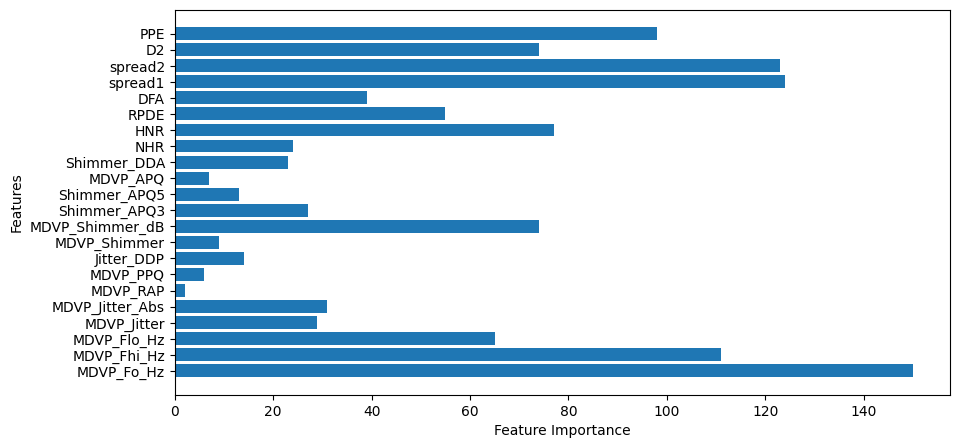

In [ ]:
import matplotlib.pyplot as plt

model.fit(X_resampled, y_resampled)
feature_importance = model.feature_importances_

# Plot importance
plt.figure(figsize=(10,5))
plt.barh(X_resampled.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

lightgbm model

In [ ]:
#basic LightGBM model
model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)

# Stratified K-Fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using cross-validation
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='f1')
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

[LightGBM] [Info] Number of positive: 117, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 235, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497872 -> initscore=-0.008511
[LightGBM] [Info] Start training from score -0.008511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 31),
        "max_depth": 6,
        "min_gain_to_split": 0.01,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 50),
        "feature_fraction": 0.75,
        "random_state": 42,
    }

    model = lgb.LGBMClassifier(**param)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='f1')

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # Run 50 iterations

# Best hyperparameters
print("Best Parameters:", study.best_params)

# Train final model with best params
best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)

[I 2025-02-20 21:53:36,714] A new study created in memory with name: no-name-68f3ba2c-e386-46de-bdc0-3a74695ab8b7
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:37,067] Trial 0 finished with value: 0.9056641604010025 and parameters: {'n_estimators': 158, 'learning_rate': 0.042895365573693126, 'num_leaves': 21, 'min_data_in_leaf': 33}. Best is trial 0 with value: 0.9056641604010025.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

[I 2025-02-20 21:53:37,681] Trial 1 finished with value: 0.9086616773057452 and parameters: {'n_estimators': 147, 'learning_rate': 0.04075701186983463, 'num_leaves': 21, 'min_data_in_leaf': 34}. Best is trial 1 with value: 0.9086616773057452.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:37,993] Trial 2 finished with value: 0.8506116200034761 and parameters: {'n_estimators': 52, 'learning_rate': 0.011145912592553804, 'num_leaves': 25, 'min_data_in_leaf': 34}. Best is trial 1 with value: 0.9086616773057452.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:38,653] Trial 3 finished with value: 0.9057327641136739 and parameters: {'n_estimators': 177, 'learning_rate': 0.010330968302947557, 'num_leaves': 29, 'min_data_in_leaf': 23}. Best is trial 1 with value: 0.9086616773057452.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 21:53:39,412] Trial 4 finished with value: 0.9157828894269573 and parameters: {'n_estimators': 166, 'learning_rate': 0.013057117668364902, 'num_leaves': 28, 'min_data_in_leaf': 24}. Best is trial 4 with value: 0.9157828894269573.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:39,577] Trial 5 finished with value: 0.9086616773057452 and parameters: {'n_estimators': 87, 'learning_rate': 0.04749005966573147, 'num_leaves': 25, 'min_data_in_leaf': 33}. Best is trial 4 with value: 0.9157828894269573.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:39,728] Trial 6 finished with value: 0.8439978600634339 and parameters: {'n_estimators': 89, 'learning_rate': 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:39,937] Trial 7 finished with value: 0.9121645021645023 and parameters: {'n_estimators': 194, 'learning_rate': 0.039238235429212204, 'num_leaves': 23, 'min_data_in_leaf': 38}. Best is trial 4 with value: 0.9157828894269573.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:40,118] Trial 8 finished with value: 0.9079017780712697 and parameters: {'n_estimators': 121, 'learning_rate': 0.08442515801954353, 'num_leaves': 24, 'min_data_in_leaf': 36}. Best is trial 4 with value: 0.9157828894269573.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:40,255] Trial 9 finished with value: 0.8433986826004322 and parameters: {'n_estimators': 67, 'learning_rate': 0.023024139171622503, 'num_leaves': 27, 'min_data_in_leaf': 45}. Best is trial 4 with value: 0.9157828894269573.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:40,513] Trial 10 finished with value: 0.9208359585214267 and parameters: {'n_estimators': 129, 'learning_rate': 0.018714350412239258, 'num_leaves': 28, 'min_data_in_leaf': 20}. Best is trial 10 with value: 0.9208359585214267.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[L

[I 2025-02-20 21:53:40,797] Trial 11 finished with value: 0.9208359585214267 and parameters: {'n_estimators': 130, 'learning_rate': 0.018440116663767176, 'num_leaves': 28, 'min_data_in_leaf': 20}. Best is trial 10 with value: 0.9208359585214267.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:41,042] Trial 12 finished with value: 0.9244319394838805 and parameters: {'n_estimators': 127, 'learning_rate': 0.020234100749527164, 'num_leaves': 30, 'min_data_in_leaf': 20}. Best is trial 12 with value: 0.9244319394838805.


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:41,251] Trial 13 finished with value: 0.9106828873572509 and parameters: {'n_estimators': 113, 'learning_rate': 0.022124868654337396, 'num_leaves': 31, 'min_data_in_leaf': 27}. Best is trial 12 with value: 0.9244319394838805.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:41,490] Trial 14 finished with value: 0.9105828595717549 and parameters: {'n_estimators': 136, 'learning_rate': 0.01645690124038836, 'num_leaves': 30, 'min_data_in_leaf': 28}. Best is trial 12 with value: 0.9244319394838805.


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:41,751] Trial 15 finished with value: 0.9203698496590788 and parameters: {'n_estimators': 105, 'learning_rate': 0.029765393883138595, 'num_leaves': 27, 'min_data_in_leaf': 21}. Best is trial 12 with value: 0.9244319394838805.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:41,931] Trial 16 finished with value: 0.9106828873572509 and parameters: {'n_estimators': 95, 'learning_rate': 0.02597922258962795, 'num_leaves': 29, 'min_data_in_leaf': 28}. Best is trial 12 with value: 0.9244319394838805.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:42,127] Trial 17 finished with value: 0.8495105622974476 and parameters: {'n_estimators': 143, 'learning_rate': 0.015482128203992768, 'num_leaves': 27, 'min_data_in_leaf': 50}. Best is trial 12 with value: 0.9244319394838805.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[L

[I 2025-02-20 21:53:42,359] Trial 18 finished with value: 0.928375627545379 and parameters: {'n_estimators': 120, 'learning_rate': 0.05820043624700264, 'num_leaves': 30, 'min_data_in_leaf': 25}. Best is trial 18 with value: 0.928375627545379.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:42,577] Trial 19 finished with value: 0.9083982683982684 and parameters: {'n_estimators': 107, 'learning_rate': 0.065616398634847, 'num_leaves': 30, 'min_data_in_leaf': 30}. Best is trial 18 with value: 0.928375627545379.


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:42,790] Trial 20 finished with value: 0.9298946293855698 and parameters: {'n_estimators': 68, 'learning_rate': 0.09979920350412844, 'num_leaves': 31, 'min_data_in_leaf': 25}. Best is trial 20 with value: 0.9298946293855698.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=25, 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:42,977] Trial 21 finished with value: 0.92827434177844 and parameters: {'n_estimators': 75, 'learning_rate': 0.09298435745152592, 'num_leaves': 31, 'min_data_in_leaf': 25}. Best is trial 20 with value: 0.9298946293855698.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 205, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.570732 -> initscore=0.284837
[LightGBM] [Info] Start training from score 0.284837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-20 21:53:43,167] Trial 22 finished with value: 0.929816549570648 and parameters: {'n_estimators': 74, 'learning_rate': 0.09209076385735872, 'num_leaves': 31, 'min_data_in_leaf': 25}. Best is trial 20 with value: 0.9298946293855698.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

[I 2025-02-20 21:53:43,342] Trial 23 finished with value: 0.9099587655389707 and parameters: {'n_estimators': 58, 'learning_rate': 0.0677492508360997, 'num_leaves': 31, 'min_data_in_leaf': 30}. Best is trial 20 with value: 0.9298946293855698.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will 

[I 2025-02-20 21:53:43,540] Trial 24 finished with value: 0.9272606526599123 and parameters: {'n_estimators': 79, 'learning_rate': 0.06960973136624059, 'num_leaves': 29, 'min_data_in_leaf': 25}. Best is trial 20 with value: 0.9298946293855698.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 21:53:43,716] Trial 25 finished with value: 0.9108538897990455 and parameters: {'n_estimators': 64, 'learning_rate': 0.05485744208446699, 'num_leaves': 30, 'min_data_in_leaf': 30}. Best is trial 20 with value: 0.9298946293855698.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:43,935] Trial 26 finished with value: 0.9260503158044141 and parameters: {'n_estimators': 75, 'learning_rate': 0.0984801399976462, 'num_leaves': 31, 'min_data_in_leaf': 23}. Best is trial 20 with value: 0.9298946293855698.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:44,145] Trial 27 finished with value: 0.9300031935277836 and parameters: {'n_estimators': 97, 'learning_rate': 0.07750378686608796, 'num_leaves': 29, 'min_data_in_leaf': 26}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:44,341] Trial 28 finished with value: 0.9179803265806546 and parameters: {'n_estimators': 97, 'learning_rate': 0.08271007535905663, 'num_leaves': 26, 'min_data_in_leaf': 40}. Best is trial 27 with value: 0.9300031935277836.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[I 2025-02-20 21:53:44,534] Trial 29 finished with value: 0.9128739088780072 and parameters: {'n_estimators': 82, 'learning_rate': 0.07791689505964906, 'num_leaves': 20, 'min_data_in_leaf': 31}. Best is trial 27 with value: 0.9300031935277836.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 21:53:44,715] Trial 30 finished with value: 0.9209489528717093 and parameters: {'n_estimators': 69, 'learning_rate': 0.04996096574041016, 'num_leaves': 29, 'min_data_in_leaf': 27}. Best is trial 27 with value: 0.9300031935277836.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 21:53:44,984] Trial 31 finished with value: 0.9217420102666004 and parameters: {'n_estimators': 116, 'learning_rate': 0.06201637905278227, 'num_leaves': 30, 'min_data_in_leaf': 26}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:45,224] Trial 32 finished with value: 0.9220243417784401 and parameters: {'n_estimators': 101, 'learning_rate': 0.09795287918268412, 'num_leaves': 30, 'min_data_in_leaf': 22}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:45,385] Trial 33 finished with value: 0.9183540321245239 and parameters: {'n_estimators': 52, 'learning_rate': 0.07803484701223415, 'num_leaves': 31, 'min_data_in_leaf': 25}. Best is trial 27 with value: 0.9300031935277836.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:45,606] Trial 34 finished with value: 0.9242815249266861 and parameters: {'n_estimators': 89, 'learning_rate': 0.03581980561548822, 'num_leaves': 29, 'min_data_in_leaf': 23}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:45,896] Trial 35 finished with value: 0.9207647307427097 and parameters: {'n_estimators': 153, 'learning_rate': 0.07366558187772199, 'num_leaves': 22, 'min_data_in_leaf': 28}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:46,059] Trial 36 finished with value: 0.9066102160986654 and parameters: {'n_estimators': 50, 'learning_rate': 0.05928776736035758, 'num_leaves': 28, 'min_data_in_leaf': 32}. Best is trial 27 with value: 0.9300031935277836.
<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:46,341] Trial 37 finished with value: 0.9211730892058763 and parameters: {'n_estimators': 112, 'learning_rate': 0.04523822359805151, 'num_leaves': 30, 'min_data_in_leaf': 35}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:46,686] Trial 38 finished with value: 0.9292970690511673 and parameters: {'n_estimators': 86, 'learning_rate': 0.08566756771256655, 'num_leaves': 29, 'min_data_in_leaf': 23}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:46,996] Trial 39 finished with value: 0.9217420102666004 and parameters: {'n_estimators': 62, 'learning_rate': 0.08725992100144143, 'num_leaves': 26, 'min_data_in_leaf': 22}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:47,336] Trial 40 finished with value: 0.9207814613815233 and parameters: {'n_estimators': 87, 'learning_rate': 0.0882097367316754, 'num_leaves': 29, 'min_data_in_leaf': 23}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:47,633] Trial 41 finished with value: 0.9285683533224518 and parameters: {'n_estimators': 95, 'learning_rate': 0.05555471555246859, 'num_leaves': 31, 'min_data_in_leaf': 24}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 205, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.570732 -> initscore=0.284837
[LightGBM] [Info] Start training from score 0.284837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-02-20 21:53:47,913] Trial 42 finished with value: 0.9229902065147966 and parameters: {'n_estimators': 73, 'learning_rate': 0.07489592424893225, 'num_leaves': 31, 'min_data_in_leaf': 24}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=0.01, min

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:48,240] Trial 43 finished with value: 0.9215961457896942 and parameters: {'n_estimators': 94, 'learning_rate': 0.05296500407638523, 'num_leaves': 24, 'min_data_in_leaf': 27}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 21:53:48,529] Trial 44 finished with value: 0.9186477184018168 and parameters: {'n_estimators': 83, 'learning_rate': 0.08385859195710467, 'num_leaves': 28, 'min_data_in_leaf': 22}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-02-20 21:53:48,758] Trial 45 finished with value: 0.9217683597323999 and parameters: {'n_estimators': 57, 'learning_rate': 0.09998414255223391, 'num_leaves': 31, 'min_data_in_leaf': 29}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 21:53:49,259] Trial 46 finished with value: 0.9291674837242135 and parameters: {'n_estimators': 178, 'learning_rate': 0.07034513994267455, 'num_leaves': 31, 'min_data_in_leaf': 24}. Best is trial 27 with value: 0.9300031935277836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 21:53:49,688] Trial 47 finished with value: 0.9355555555555556 and parameters: {'n_estimators': 158, 'learning_rate': 0.06874599692652678, 'num_leaves': 28, 'min_data_in_leaf': 26}. Best is trial 47 with value: 0.9355555555555556.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 118, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:50,173] Trial 48 finished with value: 0.9191590376836279 and parameters: {'n_estimators': 197, 'learning_rate': 0.04051851941142041, 'num_leaves': 28, 'min_data_in_leaf': 33}. Best is trial 47 with value: 0.9355555555555556.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current valu

<ipython-input-70-b30d650133dd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Info] Number of positive: 117, number of negative: 88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-02-20 21:53:50,523] Trial 49 finished with value: 0.9169683005166875 and parameters: {'n_estimators': 164, 'learning_rate': 0.09029283914502527, 'num_leaves': 27, 'min_data_in_leaf': 26}. Best is trial 47 with value: 0.9355555555555556.


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[Lig

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[163]	train's binary_logloss: 0.310086	validation's binary_logloss: 0.286926

📊 Model Performance:
Training F1 Score: 0.8783
Validation F1 Score: 0.9153
Training ROC-AUC Score: 0.9436
Validation ROC-AUC Score: 0.9606

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.93      0.90      0.92        30

    accuracy                           0.90        52
   macro avg       0.90      0.90      0.90        52
weighted avg       0.91      0.90      0.90        52



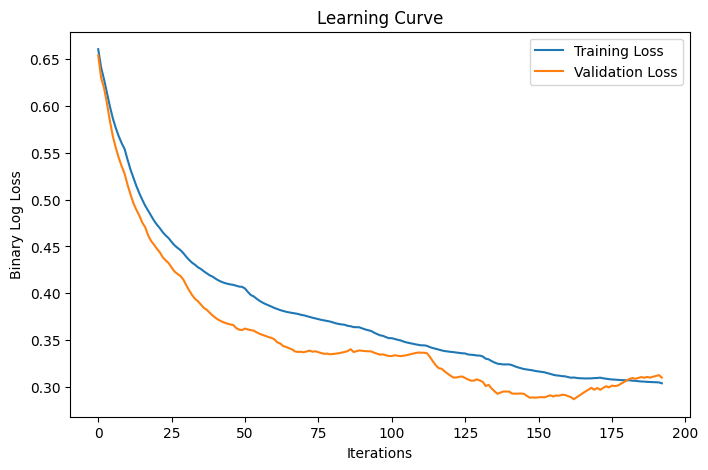

In [ ]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, roc_auc_score

# Best Parameters from Optuna
best_params = {
    'learning_rate': 0.0687,
    'num_leaves': 15,
    'max_depth': 4,
    'lambda_l1': 0.5,  # L1 Regularization
    'lambda_l2': 0.5,  # L2 Regularization
    'min_gain_to_split': 0.1,  # Increase threshold to force better splits
    'min_data_in_leaf': 55,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.6,  # Introduce bagging
    'bagging_freq': 10,
    'objective': 'binary',
    'metric': 'binary_logloss',  # Ensure metric is correctly set
    'random_state': 42,
    'verbose': -1
}

# Train-test split (80% training, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Convert to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Dictionary to store evaluation results
evals_result = {}

# Train LightGBM Model with Early Stopping
model = lgb.train(
    best_params,
    train_data,
    valid_sets=[train_data, valid_data],  # Track both training and validation
    valid_names=['train', 'validation'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30, verbose=True),
        lgb.record_evaluation(evals_result)  # Store loss values
    ]
)

# Predictions
y_train_pred = (model.predict(X_train) > 0.5).astype(int)
y_valid_pred = (model.predict(X_valid) > 0.5).astype(int)

# Probabilities for ROC-AUC
y_train_proba = model.predict(X_train)
y_valid_proba = model.predict(X_valid)

# Compute Scores
train_f1 = f1_score(y_train, y_train_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

train_roc_auc = roc_auc_score(y_train, y_train_proba)
valid_roc_auc = roc_auc_score(y_valid, y_valid_proba)

print("\n📊 Model Performance:")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Validation F1 Score: {valid_f1:.4f}")
print(f"Training ROC-AUC Score: {train_roc_auc:.4f}")
print(f"Validation ROC-AUC Score: {valid_roc_auc:.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))

# Extract Log Loss from Training History for Learning Curve
train_loss = evals_result['train']['binary_logloss']
valid_loss = evals_result['validation']['binary_logloss']

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Binary Log Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


🔄 Fold 1/5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[680]	train's binary_logloss: 0.310783	validation's binary_logloss: 0.254113

🔄 Fold 2/5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[764]	train's binary_logloss: 0.271042	validation's binary_logloss: 0.32887

🔄 Fold 3/5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[408]	train's binary_logloss: 0.31273	validation's binary_logloss: 0.44057

🔄 Fold 4/5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[666]	train's binary_logloss: 0.275364	validation's binary_logloss: 0.370283

🔄 Fold 5/5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[778]	train's binary_logloss: 0.268868	validation's binary_logloss: 0.342424

📊 Average Model Performance Across Folds:
Training F1 Score: 0.9001 ± 0.0146


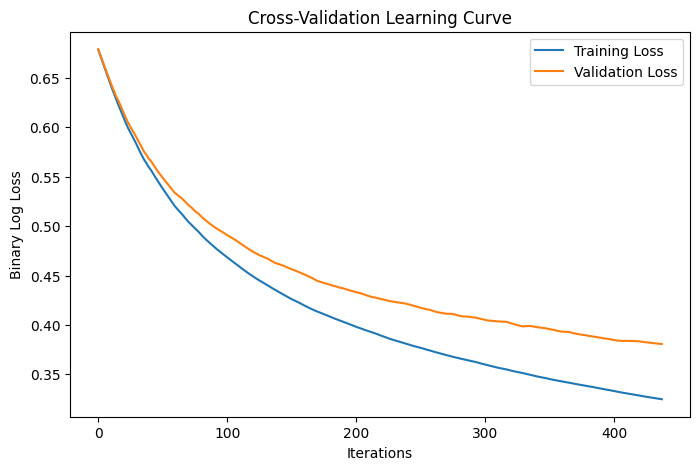

In [ ]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, roc_auc_score

# Best Parameters from Optuna
best_params = {
    'learning_rate': 0.012,
    'num_leaves': 7,
    'max_depth': 4,
    'lambda_l1': 0.1,
    'lambda_l2': 1.2,
    'min_gain_to_split': 0.085,
    'min_data_in_leaf': 55,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.65,
    'bagging_freq': 6,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 42,
    'verbose': -1
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores and losses
train_f1_scores, valid_f1_scores = [], []
train_roc_auc_scores, valid_roc_auc_scores = [], []
train_losses, valid_losses = [], []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_resampled, y_resampled), 1):
    print(f"\n🔄 Fold {fold}/5")

    # Train-validation split for this fold
    X_train, X_valid = X_resampled.iloc[train_idx], X_resampled.iloc[valid_idx]
    y_train, y_valid = y_resampled.iloc[train_idx], y_resampled.iloc[valid_idx]

    # Convert to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # Dictionary to store evaluation results
    evals_result = {}

    # Train LightGBM Model with Early Stopping
    model = lgb.train(
        best_params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'validation'],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=30, verbose=True),
            lgb.record_evaluation(evals_result)  # Store loss values
        ]
    )

    # Predictions
    y_train_pred = (model.predict(X_train) >= 0.5).astype(int)
    y_valid_pred = (model.predict(X_valid) >= 0.5).astype(int)

    # Probabilities for ROC-AUC
    y_train_proba = model.predict(X_train)
    y_valid_proba = model.predict(X_valid)

    # Compute Scores
    train_f1_scores.append(f1_score(y_train, y_train_pred))
    valid_f1_scores.append(f1_score(y_valid, y_valid_pred))

    train_roc_auc_scores.append(roc_auc_score(y_train, y_train_proba))
    valid_roc_auc_scores.append(roc_auc_score(y_valid, y_valid_proba))

    # Store Log Loss for Learning Curve
    train_losses.append(evals_result['train']['binary_logloss'])
    valid_losses.append(evals_result['validation']['binary_logloss'])

# Ensure all loss sequences have the same length
min_length = min(len(loss) for loss in train_losses)

train_losses_trimmed = np.array([loss[:min_length] for loss in train_losses])
valid_losses_trimmed = np.array([loss[:min_length] for loss in valid_losses])

# Compute mean loss across folds
mean_train_loss = np.mean(train_losses_trimmed, axis=0)
mean_valid_loss = np.mean(valid_losses_trimmed, axis=0)

# Print Average Performance
print("\n📊 Average Model Performance Across Folds:")
print(f"Training F1 Score: {np.mean(train_f1_scores):.4f} ± {np.std(train_f1_scores):.4f}")
print(f"Validation F1 Score: {np.mean(valid_f1_scores):.4f} ± {np.std(valid_f1_scores):.4f}")
print(f"Training ROC-AUC Score: {np.mean(train_roc_auc_scores):.4f} ± {np.std(train_roc_auc_scores):.4f}")
print(f"Validation ROC-AUC Score: {np.mean(valid_roc_auc_scores):.4f} ± {np.std(valid_roc_auc_scores):.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))

# Plot Learning Curve (Average Across Folds)
plt.figure(figsize=(8, 5))
plt.plot(mean_train_loss, label='Training Loss')
plt.plot(mean_valid_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Binary Log Loss')
plt.title('Cross-Validation Learning Curve')
plt.legend()
plt.show()


In [ ]:
# Train the model
model.fit(X_resampled, y_resampled)

# Predict on the original dataset (to compare performance)
y_pred = model.predict(X)

# Evaluate the model
print("Accuracy:", accuracy_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("ROC-AUC Score:", roc_auc_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5070747826569374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5070747826569374
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5070747826569374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5070747826569374
[LightGBM] [Info] Number of positive: 147, number of negative: 110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 257, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571984 -> initscore=0.289952
[LightGBM] [Inf

checking first model for overfitting

In [ ]:
X.columns = (
    X.columns
    .str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)  # Replace special characters
    .str.strip("_")  # Remove leading/trailing underscores
)

In [ ]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

# Define model
model = LGBMClassifier(random_state=42)

# Perform 5-fold cross-validation on original imbalanced data
cv_scores_original = cross_val_score(model, X, y, cv=5, scoring="f1")
print("F1 Scores on Original Data:", cv_scores_original)
print("Mean F1 Score (Original Data):", np.mean(cv_scores_original))

# Perform 5-fold cross-validation on SMOTE-balanced data
cv_scores_smote = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring="f1")
print("F1 Scores on SMOTE Data:", cv_scores_smote)
print("Mean F1 Score (SMOTE Data):", np.mean(cv_scores_smote))


[LightGBM] [Info] Number of positive: 117, number of negative: 39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

tells that the original data was more stable as the variation is only from 85 to 97 while after smote it is from 80 to 94 but mean values for both the models is same approx 89 hence, not much overfitting

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring="f1")

print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

[LightGBM] [Info] Number of positive: 117, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 235, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497872 -> initscore=-0.008511
[LightGBM] [Info] Start training from score -0.008511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

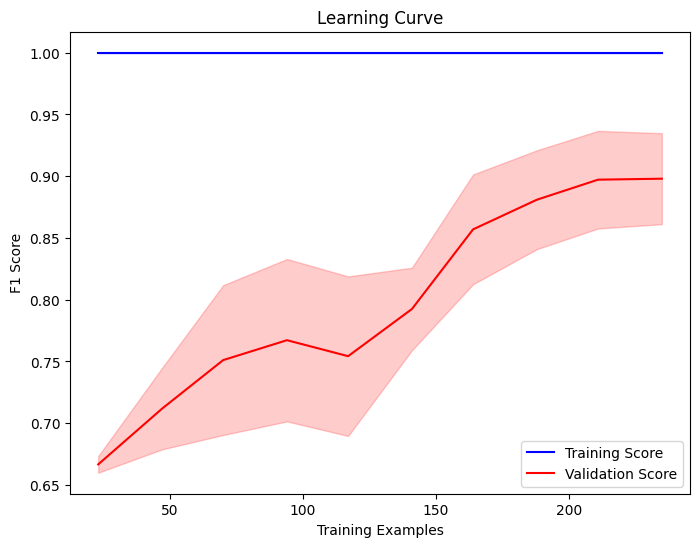

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    model, X_resampled, y_resampled, cv=5, scoring="f1", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, val_mean, label="Validation Score", color="red")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.2)
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.show()

clearly overfitting

or ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Train LightGBM on ADASYN data
model.fit(X_adasyn, y_adasyn)

# Evaluate with Cross-Validation
cv_scores_adasyn = cross_val_score(model, X_adasyn, y_adasyn, cv=5, scoring="f1")

print("F1 Scores on ADASYN Data:", cv_scores_adasyn)
print("Mean F1 Score (ADASYN Data):", np.mean(cv_scores_adasyn))


[LightGBM] [Info] Number of positive: 147, number of negative: 146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 293, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
# Train the model
model.fit(X_adasyn, y_adasyn)

# Predict on the original dataset (to compare performance)
y_pred = model.predict(X)

# Evaluate the model
print("Accuracy:", accuracy_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("ROC-AUC Score:", roc_auc_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

[LightGBM] [Info] Number of positive: 147, number of negative: 146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 293, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

this is clearly overfitting so dropping this out!